# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [3]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [635]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [636]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 데이터 전처리 및 파생변수 생성

- Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [637]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [638]:
get_date(df)
get_date(test)

In [639]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days
test['Day_Range'] = (test['Date'] - pd.datetime(2010, 1, 1)).dt.days

- 한 해의 몇 주차인지 나타내는 변수

In [640]:
df['WeekOfYear'] = df['Date'].dt.weekofyear
test['WeekOfYear'] = test['Date'].dt.weekofyear

- 공휴일 변수를 숫자로 변경

In [641]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)

- 화씨를 섭씨로 변환

In [642]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9
test['Temperature'] = (test['Temperature'] - 32) * 5/9

- 프로모션의 결측치를 $0$으로 대체

In [643]:
df.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

- 총 프로모션 비용 변수 생성

In [644]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)
test['Promotion_Cost'] = test[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

In [645]:
df.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5'], axis=1, inplace=True)
test.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5'], axis=1, inplace=True)

- month의 몇 번재 week인지 나타내는 변수 생성

In [646]:
df['WeekOfMonth'] = df['Day'].apply(lambda x: (x-1) // 7 + 1)
test['WeekOfMonth'] = test['Day'].apply(lambda x: (x-1) // 7 + 1)

- 크리스마스가 몇 주일 남았는지 나타내는 변수를 생성

`-` 크리스마스는 12월 4주차에 존재함

`-` 12월 3주차는 2, 4주차는 3, 5주차는 1, 그 외는 0으로 코딩 (매출액이 기준)

In [647]:
def christmas_week(date):
    month = date.month
    week_of_month = (date.day-1) // 7 + 1
    if month == 12:
        if week_of_month == 3:
            return 2
        elif week_of_month == 4:
            return 3
        elif week_of_month == 5:
            return 1
    return 0

In [648]:
df['IsChristmasWeek'] = df['Date'].apply(lambda date: christmas_week(date))
test['IsChristmasWeek'] = test['Date'].apply(lambda date: christmas_week(date))

- 전날에 비해 온도, 연료 가격, 실업률이 얼마나 변했는지 나타내는 변수 생성

<AxesSubplot:>

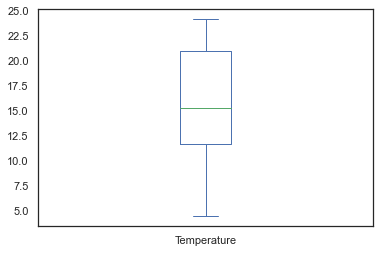

In [654]:
test.query('Month == 10')['Temperature'].plot.box()

In [649]:
date = sorted(df['Date'].unique())

In [136]:
def feature_diff(df, is_test=False) -> None:
    df['Temperature_Diff'] = 0
    df['Fuel_Price_Diff'] = 0
    df['Unemployment_Diff'] = 0
    
    if not is_test:
        for store in tqdm(range(1, 46)):
            for i in range(1, len(date)):
                current_date = date[i]
                previous_date = date[i - 1]
                df_  = df.query('Store == @store')
                for feature in ['Temperature', 'Fuel_Price', 'Unemployment']:
                    df.loc[(df['Store'] == store) & (df['Date'] == current_date), f'{feature}_Diff'] = df_.query('Date == @current_date')[feature].item()\
                                                                                                       - df_.query('Date == @previous_date')[feature].item()
#     else:
#         test_date = sorted(df['Date'].unique())
#         for store in tqdm(range(1, 46)):
#             for test_d in test_date:
#                 current_date = test_d
#                 previous_date = date[0]
#                 for d in date:
#                     if test_d > d:
#                         previous_date = d
#                     else:
#                         break
                        
#                 df_  = df.query('Store == @store')
#                 for feature in ['Temperature', 'Fuel_Price', 'Unemployment']:
#                     df.loc[(df['Store'] == store) & (df['Date'] == current_date), f'{feature}_Diff'] = df_.query('Date == @current_date')[feature].item()\
#                                                                                                        - df_.query('Date == @previous_date')[feature].item()

In [137]:
feature_diff(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:29<00:00,  2.00s/it]


In [138]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,...,Month,Day,Day_Range,WeekOfYear,Promotion_Cost,WeekOfMonth,IsChristmasWeek,Temperature_Diff,Fuel_Price_Diff,Unemployment_Diff
0,1,2010-05-02,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,8.106,...,5,2,121,17,0.0,1,0,-13.944444,-0.208,0.298
1,1,2010-12-02,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,8.106,...,12,2,335,48,0.0,1,0,-14.450000,-0.187,0.268
2,1,2010-02-19,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,8.106,...,2,19,49,7,0.0,3,0,-22.766667,-0.155,0.319
3,1,2010-02-26,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,8.106,...,2,26,56,8,0.0,4,0,3.722222,0.047,0.000
4,1,2010-05-03,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,8.106,...,5,3,122,18,0.0,1,0,2.327778,0.053,0.000


- 쇼핑몰 지점 군집화

`-` 군집화되는 쇼핑몰이 거의 없어 성능 차이가 없음

In [17]:
cor_list = []
for store in list(range(1, 46)):
    df_ = df.query('Store == @store')
    cor = np.corrcoef(df_['Day_Range'], df_['Weekly_Sales'])[1, 0]
    cor_list.append(cor)

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

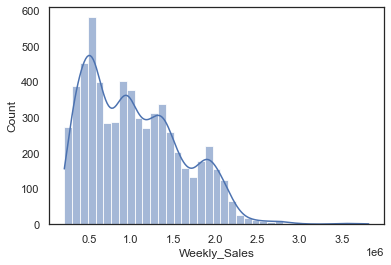

In [18]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

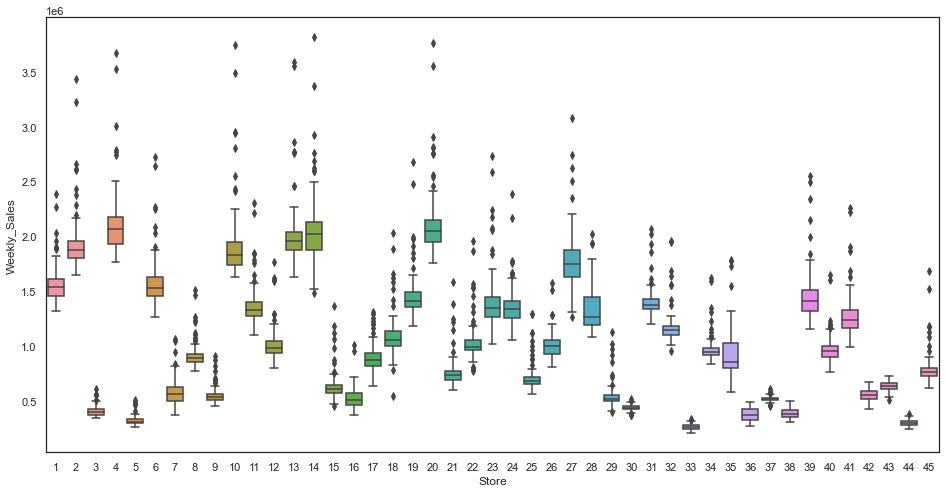

In [19]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 비슷한 분포를 띄는 쇼핑몰 지점을 군집화하자 (매출액의 중앙값과 IQR, 지난 일수와의 상관계수가 비슷해야 함)

In [18]:
tmp = df.groupby(by='Store').agg({'Weekly_Sales':[np.median, lambda x: np.quantile(x, q=0.75) - np.quantile(x, q=0.25)]}).\
        reset_index().rename(columns={'<lambda_0>':'IQR'}).melt(id_vars='Store').\
        rename(columns={'variable_1':'statistic'}).drop('variable_0', axis=1)

<AxesSubplot:>

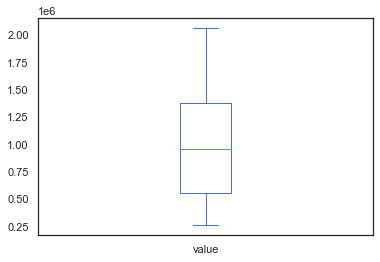

In [21]:
tmp.query('statistic == "median"').value.plot.box()

<AxesSubplot:>

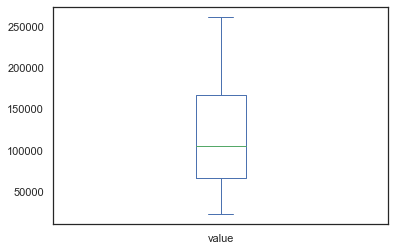

In [22]:
tmp.query('statistic == "IQR"').value.plot.box()

`-` 매출액의 중앙값과 사분위수 범위가 비슷한 쇼핑몰 지점끼리 군집화하겠다

`-` 나의 능지 문제로 일단은 일일이 분류하겠다

`-` 나중에 함수로 만들든 클래스로 만들든 해가지고 이를 사용해 분류하겠다


In [19]:
median_bins = [-np.inf]
for i in range(1, 8):
    value = np.quantile(tmp.query('statistic == "median"').value, q=i/8)
    median_bins.append(value)
median_bins.append(np.inf)

In [20]:
cuts = pd.cut(tmp.query('statistic == "median"').value, bins=median_bins, labels=list(range(1, 9)))

In [21]:
store_df = pd.DataFrame(data=range(1, 46), columns=['Store'])

In [22]:
store_df['Cut'] = cuts

In [23]:
store_df = store_df.merge(tmp.query('statistic == "median"').drop('statistic', axis=1)).\
                    rename(columns={'value':'median'}).\
                    merge(tmp.query('statistic == "IQR"').drop('statistic', axis=1)).\
                    rename(columns={'value':'IQR'})

- 사후처리

`-` 군집내에서 쇼핑몰 지점별 중앙값의 차이가 큰 경우 군집을 쪼개겠다

`-` 또한, 군집내에서 사분위수 범위가 유사한 것끼리 다시 군집화하겠다

`-` 성능을 올리기 위해선 필수이다 (얼마나 올라갈진...)

|군집 번호| 매출액의 범위|쇼핑몰 지점|
|:-:|:-:|:-:|
|1|$<416493$|33, 44, 5, 36, 38, 3|
|2|$<556046$|30, 16, 37, 29, 9 ,42|
|3|$<752464$|7, 15, 43, 25, 21|
|4|$<954233$|45, 35, 17, 8, 34, 40|
|5|$<1191838$|12, 22, 26, 18, 32|
|6|$<1378340$|41, 28, 11, 24, 23, 31|
|7|$<1786338$|19, 39, 6, 1, 27|
|8|$\geq 1786338$|10, 2, 13, 14, 20, 4|

`-` 그룹 8 다시 분류

2와 10, 13, 14, 20, 4

`-` 그룹 7 다시 분류

19, 39, 6,  1, 27

`-` 그룹 6 다시 분류

24, 23, 31, 11과 24, 41, 28

`-` 그룹 5 다시 분류

18, 32, 12, 22, 26

`-` 그룹 4 다시 분류

34와 40, 17, 35, 8

`-` 그룹 3 다시 분류

45(그룹3과 4의 경계)와 21, 25, 43(특별함), 7, 15

`-` 그룹 2 다시 분류

42(특별함), 37(특별함), 30(특별함), 16, 29, 9

`-` 그룹 1 다시 분류

36(하강), 38(상승), 33(특별함), 5, 44

## 모델링

In [114]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [139]:
SEED = 22

In [140]:
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

In [275]:
def OOF_predict(model, X, y, test, SKfold, stratify=None, original_score=False):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 RMSE score와 예측한 test를 return
    """ 
    model_valid_SAE = []
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))
    
    if stratify is not None:
        split_fold = SKfold.split(X, X[stratify])
    else:
        split_fold = SKfold.split(X)

    for i, (train_idx, valid_idx) in enumerate(split_fold):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        ## 모델 적합
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  #eval_metric='rmse', 
                  verbose=0,
                  early_stopping_rounds=200
                 )
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(RMSE(y_train, train_pred)) ## train RMSE
        model_valid_score.append(RMSE(y_valid, valid_pred)) ## valid RMSE
        model_valid_SAE.extend(np.square(y_valid - valid_pred)) ## square of absolute error
        model_pred += test_pred / SKfold.n_splits ## test 예측값(k Fold)
              
    if original_score:
        return model_train_score, model_valid_score, model_valid_SAE, model_pred
    return model_train_score, model_valid_score, model_pred

`-` 랜덤 포레스트 모델과 그래디언트 부스팅 모델은 성능이 좋지 않았다

In [142]:
RF = RandomForestRegressor(n_estimators=300,
                           max_depth=18,
                           random_state=SEED)

EXT = ExtraTreesRegressor(n_estimators=300,
                           max_depth=18,
                           random_state=SEED)

In [143]:
CB = CatBoostRegressor(n_estimators=3000,
                       learning_rate=0.03,
                       max_depth=7,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=7,
                   random_state=SEED)

LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     max_depth=7,
                     min_child_samples=2,
                     random_state=SEED)

- Month 변수를 1월, 12월, 그 외 나머지로 구성

In [259]:
# df['Month2'] = df['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))
# test['Month2'] = test['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))

- 사용할 변수

`-` 데이터가 일주일 간격으로 존재하여 `Day` 변수도 추가했다 (하루 간격이었으면 제외했음)

`-` `Day_Range` 변수는 기온에 대한 정보와 날짜 정보를 담고 있다

In [399]:
features = [
            'Store',
            'Temperature',
            'Fuel_Price',
            'Unemployment',
            #'IsHoliday',
            #'Promotion_Cost',
            #'Year',
            'Day',
            'IsChristmasWeek',
            'Month',
            #'Month2',
            'WeekOfYear',
            'WeekOfMonth',
            #'Day_Range',
            #'Temperature_Diff'
           ]

In [400]:
target = df['Weekly_Sales']

In [401]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [402]:
k = 10
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

- 모델 학습

`-` RF, EXT 모델의 성능은 좋지 않다

- RF

In [67]:
_, RF_valid_RMSE1, RF_test_pred1 = OOF_predict(RF, df2, target, test2, skfold1, stratify='Store')
_, RF_valid_RMSE2, RF_test_pred2 = OOF_predict(RF, df2, target, test2, skfold2, stratify='Store')
print(f'{RF.__class__.__name__} -> Mean: {np.mean(RF_valid_RMSE1 + RF_valid_RMSE2)}, Std: {np.std(RF_valid_RMSE1 + RF_valid_RMSE2)}')

RandomForestRegressor -> Mean: 109924.91976758649, Std: 10244.769607843862


- EXT

In [71]:
_, EXT_valid_RMSE1, EXT_test_pred1 = OOF_predict(EXT, df2, target, test2, skfold1, stratify='Store')
_, EXT_valid_RMSE2, EXT_test_pred2 = OOF_predict(EXT, df2, target, test2, skfold2, stratify='Store')
print(f'{EXT.__class__.__name__} -> Mean: {np.mean(EXT_valid_RMSE1 + EXT_valid_RMSE2)}, Std: {np.std(EXT_valid_RMSE1 + EXT_valid_RMSE2)}')

ExtraTreesRegressor -> Mean: 145061.73794414362, Std: 12217.784447607528


- CB

In [57]:
_, CB_valid_RMSE1, CB_test_pred1 = OOF_predict(CB, df2, target, test2, skfold1, stratify='Store')
_, CB_valid_RMSE2, CB_test_pred2 = OOF_predict(CB, df2, target, test2, skfold2, stratify='Store')
print(f'{CB.__class__.__name__} -> Mean: {np.mean(CB_valid_RMSE1 + CB_valid_RMSE2)}, Std: {np.std(CB_valid_RMSE1 + CB_valid_RMSE2)}')

CatBoostRegressor -> Mean: 79738.92763592312, Std: 5731.959478252804


- XGB

In [60]:
_, XGB_valid_RMSE1, XGB_test_pred1 = OOF_predict(XGB, df2, target, test2, skfold1, stratify='Store')
_, XGB_valid_RMSE2, XGB_test_pred2 = OOF_predict(XGB, df2, target, test2, skfold2, stratify='Store')
print(f'{XGB.__class__.__name__} -> Mean: {np.mean(XGB_valid_RMSE1 + XGB_valid_RMSE2)}, Std: {np.std(XGB_valid_RMSE1 + XGB_valid_RMSE2)}')

XGBRegressor -> Mean: 94365.03624550627, Std: 10254.552883121767


- LGBM

In [180]:
_, LGBM_valid_RMSE1, LGBM_test_pred1 = OOF_predict(LGBM, df2, target, test2, skfold1, stratify='Store')
_, LGBM_valid_RMSE2, LGBM_test_pred2 = OOF_predict(LGBM, df2, target, test2, skfold2, stratify='Store')
print(f'{LGBM.__class__.__name__} -> Mean: {np.mean(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}, Std: {np.std(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}')

LGBMRegressor -> Mean: 79685.80568992576, Std: 7307.979991065404


`-` LGBM 모델의 성능이 가장 우수하다

- test 예측 및 제출

`-` test 데이터의 경우 행이 180개로 train 데이터에 비해 매우 적다

`-` 연도는 2012년만 존재하며 월의 경우 5월, 10월, 12월만 존재한다

`-` 오버피팅을 주의해야 한다

`-` LGBM 모델과 XGB 모델은 성능이 좋지 않았으며 Catboost 모델의 성능은 나쁘지 않다

In [142]:
submission['Weekly_Sales'] = (CB_test_pred1 + CB_test_pred2) / 2
submission.head()

,id,Weekly_Sales
0,1,1.629705e+06
1,2,1.556559e+06
2,3,1.258371e+06
3,4,1.271491e+06
4,5,1.837574e+06


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

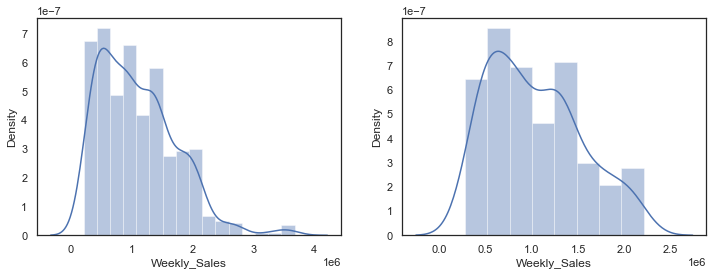

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [403]:
# submission.to_csv('./Data/submission5.csv', index=False)

## 쇼핑몰 지점별 모델 생성

`-` 쇼핑몰마다 주간 매출액의 분포가 상이하여 비슷한 분포를 띄는 쇼핑몰끼리 그룹화하려고 했다

`-` 그런데 굳이 그룹화 하지않고 쇼핑몰 지점에 따른 모델을 생성하여 학습하고자 했다 

`-` 원핫인코딩을 사용하면 피쳐의 개수가 너무 많아져서 쇼핑몰 지점마다 모델을 생성

`-` 기존의 존재하지 않는 새로운 쇼핑몰이라면 전체 데이터로 학습시킨 모델을 사용했다

`-` 그러나 test 데이터에서 새로운 쇼핑몰은 등장하지 않았다

In [433]:
k = 10
skfold1 = KFold(k, shuffle=True, random_state=SEED+2)
#skfold2 = KFold(k, shuffle=True, random_state=SEED*2)

In [446]:
CB = CatBoostRegressor(n_estimators=3000,
                       learning_rate=0.03,
                       max_depth=5,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

In [447]:
XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=7,
                   random_state=SEED)

In [448]:
LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     max_depth=7,
                     min_child_samples=3,
                     random_state=SEED)

In [449]:
valid_RMSE = []
valid_SAE = []
preds = {}
model = CB
for store in tqdm(range(1, 46)):
    df3 = df.query('Store == @store')
    target = df3['Weekly_Sales']
    df3 = df3[features].drop('Store', axis=1)
    test3 = test2.query('Store == @store')
    test3 = test3[features].drop('Store', axis=1)
    _, model_valid_RMSE, model_valid_SAE, model_test_pred = OOF_predict(model, df3, target, test3, skfold1, original_score=True)
    #_, model_valid_RMSE2, model_valid_SAE2, model_test_pred2 = OOF_predict(model, df3, target, test3, skfold2, original_score=True)
    
    valid_RMSE.extend(model_valid_RMSE 
                      #+ model_valid_RMSE2
                     )
    valid_SAE.extend(model_valid_SAE 
                     #+ model_valid_SAE2
                    )
    preds[store] = model_test_pred 
    print(f'{store} -> Mean: {np.mean(model_valid_RMSE)} Std: {np.std(model_valid_RMSE)}')

print(f'쇼핑몰 지점별 RMSE의 평균: {np.mean(valid_RMSE)}')
print(f'Mean RMSE: {np.sqrt(np.mean(valid_SAE))}')

  2%|█▊                                                                                 | 1/45 [00:22<16:22, 22.33s/it]Custom logger is already specified. Specify more than one logger at same time is not thread safe.

1 -> Mean: 71626.3546079936 Std: 21535.106240415305


  4%|███▋                                                                               | 2/45 [00:51<18:43, 26.12s/it]

2 -> Mean: 102663.42679329865 Std: 36087.414517216675


  7%|█████▌                                                                             | 3/45 [01:08<15:38, 22.34s/it]

3 -> Mean: 24193.152275323988 Std: 7026.096081723979


  9%|███████▍                                                                           | 4/45 [01:25<13:40, 20.02s/it]

4 -> Mean: 107702.24586375341 Std: 34192.19991473571


 11%|█████████▏                                                                         | 5/45 [01:41<12:19, 18.49s/it]

5 -> Mean: 20200.971802085358 Std: 6411.253371914664


 13%|███████████                                                                        | 6/45 [02:01<12:25, 19.11s/it]

6 -> Mean: 98460.8866978072 Std: 26060.451710618505


 16%|████████████▉                                                                      | 7/45 [02:17<11:25, 18.03s/it]

7 -> Mean: 53917.593986423584 Std: 16329.79656746314


 18%|██████████████▊                                                                    | 8/45 [02:30<10:13, 16.57s/it]

8 -> Mean: 56846.69498457744 Std: 14906.25307590329


 20%|████████████████▌                                                                  | 9/45 [02:48<10:11, 16.99s/it]

9 -> Mean: 35653.069672170524 Std: 10556.023741038864


 22%|██████████████████▏                                                               | 10/45 [02:59<08:45, 15.00s/it]

10 -> Mean: 151106.08400730538 Std: 42176.04434977088


 24%|████████████████████                                                              | 11/45 [03:15<08:48, 15.55s/it]

11 -> Mean: 75586.16343235988 Std: 20439.8423130985


 27%|█████████████████████▊                                                            | 12/45 [03:30<08:18, 15.12s/it]

12 -> Mean: 68158.27281059211 Std: 32054.467959211346


 29%|███████████████████████▋                                                          | 13/45 [03:42<07:37, 14.29s/it]

13 -> Mean: 132493.19481025654 Std: 44492.22500528186


 31%|█████████████████████████▌                                                        | 14/45 [04:03<08:21, 16.18s/it]

14 -> Mean: 154597.96176732302 Std: 58879.155533727455


 33%|███████████████████████████▎                                                      | 15/45 [04:18<07:58, 15.96s/it]

15 -> Mean: 50833.69074832935 Std: 19458.283464422177


 36%|█████████████████████████████▏                                                    | 16/45 [04:32<07:24, 15.32s/it]

16 -> Mean: 38170.44599714597 Std: 11554.093838569881


 38%|██████████████████████████████▉                                                   | 17/45 [04:43<06:29, 13.92s/it]

17 -> Mean: 73043.09888807025 Std: 22115.164603586312


 40%|████████████████████████████████▊                                                 | 18/45 [05:00<06:47, 15.09s/it]

18 -> Mean: 90791.66854637348 Std: 31968.035862664816


 42%|██████████████████████████████████▌                                               | 19/45 [05:15<06:28, 14.93s/it]

19 -> Mean: 87978.95360242223 Std: 23984.07764698314


 44%|████████████████████████████████████▍                                             | 20/45 [05:28<06:00, 14.43s/it]

20 -> Mean: 142817.77873579558 Std: 38779.799575012265


 47%|██████████████████████████████████████▎                                           | 21/45 [05:45<06:07, 15.29s/it]

21 -> Mean: 63572.47100630701 Std: 23017.121814613056


 49%|████████████████████████████████████████                                          | 22/45 [05:59<05:39, 14.77s/it]

22 -> Mean: 82093.49199696627 Std: 27512.285550054487


 51%|█████████████████████████████████████████▉                                        | 23/45 [06:13<05:20, 14.58s/it]

23 -> Mean: 118389.63891541174 Std: 25084.114015946187


 53%|███████████████████████████████████████████▋                                      | 24/45 [06:24<04:44, 13.55s/it]

24 -> Mean: 84215.09141138798 Std: 25560.465005764636


 56%|█████████████████████████████████████████████▌                                    | 25/45 [06:39<04:38, 13.93s/it]

25 -> Mean: 53866.135442406696 Std: 11950.417188715626


 58%|███████████████████████████████████████████████▍                                  | 26/45 [06:55<04:35, 14.52s/it]

26 -> Mean: 46394.88420613564 Std: 10316.959933282964


 60%|█████████████████████████████████████████████████▏                                | 27/45 [07:08<04:14, 14.12s/it]

27 -> Mean: 132756.3392425393 Std: 47150.72180631519


 62%|███████████████████████████████████████████████████                               | 28/45 [07:21<03:54, 13.80s/it]

28 -> Mean: 91816.43040192427 Std: 31688.63646366963


 64%|████████████████████████████████████████████████████▊                             | 29/45 [07:33<03:31, 13.24s/it]

29 -> Mean: 51748.57889818476 Std: 20355.77062304265


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [07:44<03:05, 12.37s/it]

30 -> Mean: 14102.585609899746 Std: 2913.264641015926


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [08:02<03:20, 14.29s/it]

31 -> Mean: 58888.03442188761 Std: 20428.296810616503


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [08:20<03:19, 15.36s/it]

32 -> Mean: 67787.29349385011 Std: 21227.783267266732


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [08:38<03:11, 16.00s/it]

33 -> Mean: 10550.973638865364 Std: 1909.643501537455


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [08:49<02:40, 14.58s/it]

34 -> Mean: 46532.702099888396 Std: 12618.249820435567


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [09:04<02:28, 14.87s/it]

35 -> Mean: 90084.03495327852 Std: 37203.455323454495


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [09:15<02:02, 13.63s/it]

36 -> Mean: 15935.286170077443 Std: 3179.951947550225


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [09:24<01:36, 12.06s/it]

37 -> Mean: 14739.861683740251 Std: 3315.8669406553886


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [09:34<01:19, 11.42s/it]

38 -> Mean: 12675.89354728351 Std: 2582.360117706763


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [09:49<01:15, 12.62s/it]

39 -> Mean: 100324.45193288615 Std: 33467.580347765186


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [10:06<01:09, 13.87s/it]

40 -> Mean: 46941.36335415739 Std: 9454.923700273861


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [10:18<00:53, 13.45s/it]

41 -> Mean: 91419.84814211787 Std: 39104.25844536196


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [10:36<00:44, 14.72s/it]

42 -> Mean: 16421.68147459614 Std: 4600.622671553501


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [10:46<00:26, 13.25s/it]

43 -> Mean: 23253.098682945158 Std: 4950.262938607256


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [10:57<00:12, 12.82s/it]

44 -> Mean: 10440.739075818163 Std: 2913.2205300647834


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [11:12<00:00, 14.94s/it]

45 -> Mean: 59855.048318053654 Std: 23286.87105261504
쇼핑몰 지점별 RMSE의 평균: 67592.1704033337
Mean RMSE: 82463.93895807197


In [450]:
predictions = pd.DataFrame(data=preds[1])
for i in range(2, 46):
    predictions = predictions.append(pd.DataFrame(data=preds[i]))
predictions = predictions.reset_index().drop('index', axis=1).rename(columns={0:'target'})

In [451]:
submission['Weekly_Sales'] = predictions['target'] 

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

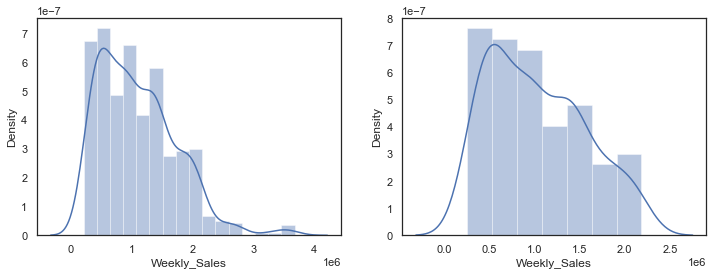

In [452]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [705]:
# submission.to_csv('./Data/submission20.csv', index=False)